In [36]:
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

True

In [3]:
# duckdb.sql("INSTALL postgres;")
duckdb.sql("load postgres;")

In [4]:
# attach postgres database
duckdb.sql(
    f"ATTACH 'dbname={os.getenv('DB_NAME')} user={os.getenv('DB_USER')} host={os.getenv('DB_HOST')} password={os.getenv('DB_PASSWORD')} port={os.getenv('DB_PORT')}' AS supabase (TYPE postgres, SCHEMA 'public');"
)

In [5]:
# initial query to test
duckdb.sql("select * from supabase.anime limit 10;").df()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [6]:
genre_denest_query = """
select 
  lower(trim(UNNEST(STRING_SPLIT(genre, ','))))
from supabase.anime
group by genre
"""

duckdb.sql(genre_denest_query)

┌──────────────────────────────────────────────────────┐
│ lower(main."trim"(unnest(string_split(genre, ',')))) │
│                       varchar                        │
├──────────────────────────────────────────────────────┤
│ action                                               │
│ adventure                                            │
│ comedy                                               │
│ mecha                                                │
│ sci-fi                                               │
│ comedy                                               │
│ drama                                                │
│ romance                                              │
│ shounen                                              │
│ mystery                                              │
│    ·                                                 │
│    ·                                                 │
│    ·                                                 │
│ shounen                      

In [7]:
genre_query = """
select 
  lower(trim(UNNEST(STRING_SPLIT(genre, ',')))) AS genre,
  count(genre) as genre_popularity
from supabase.anime
group by genre
order by genre_popularity desc;
"""
duckdb.sql(genre_query)

┌───────────────┬──────────────────┐
│     genre     │ genre_popularity │
│    varchar    │      int64       │
├───────────────┼──────────────────┤
│ comedy        │              245 │
│ music         │              196 │
│ comedy        │               93 │
│ slice of life │               93 │
│ fantasy       │               63 │
│ action        │               62 │
│ sci-fi        │               62 │
│ mecha         │               62 │
│ slice of life │               60 │
│ comedy        │               60 │
│   ·           │                · │
│   ·           │                · │
│   ·           │                · │
│ slice of life │                1 │
│ shounen       │                1 │
│ romance       │                1 │
│ harem         │                1 │
│ ecchi         │                1 │
│ comedy        │                1 │
│ police        │                1 │
│ mystery       │                1 │
│ comedy        │                1 │
│ action        │                1 │
├

In [8]:
type_query = """
SELECT
  type,
  count(type) as type_popularity
from supabase.anime
group by type
order by type_popularity desc
"""

duckdb.sql(type_query)

┌─────────┬─────────────────┐
│  type   │ type_popularity │
│ varchar │      int64      │
├─────────┼─────────────────┤
│ TV      │            2939 │
│ OVA     │            1438 │
│ Movie   │            1296 │
│ Special │            1294 │
│ ONA     │             324 │
│ Music   │             295 │
└─────────┴─────────────────┘

In [9]:
type_rating_query = """
SELECT
  type,
  avg(rating)::decimal(15,2) as average_rating,
  median(rating) as median_rating,
  min(rating) as min_rating,
  max(rating) as max_rating,
from supabase.anime
group by type
order by average_rating desc, median_rating desc 
"""

duckdb.sql(type_rating_query)

┌─────────┬────────────────┬───────────────┬────────────┬────────────┐
│  type   │ average_rating │ median_rating │ min_rating │ max_rating │
│ varchar │ decimal(15,2)  │    double     │   double   │   double   │
├─────────┼────────────────┼───────────────┼────────────┼────────────┤
│ TV      │           7.12 │          7.11 │       5.28 │       9.26 │
│ Movie   │           6.98 │          7.02 │       5.27 │       9.37 │
│ Special │           6.79 │          6.78 │       5.27 │       8.66 │
│ OVA     │           6.73 │          6.68 │       5.27 │       9.11 │
│ ONA     │           6.34 │          6.24 │       5.27 │       8.26 │
│ Music   │           6.16 │          6.06 │       5.27 │       8.38 │
└─────────┴────────────────┴───────────────┴────────────┴────────────┘

In [10]:
type_members_query = """
SELECT
  type,
  avg(members)::int64() as average_members,
  median(members)::int64() as median_members,
  min(members) as min_members,
  max(members) as max_members,
from supabase.anime
group by type
order by average_members desc, median_members desc 
"""

duckdb.sql(type_members_query)

┌─────────┬─────────────────┬────────────────┬─────────────┬─────────────┐
│  type   │ average_members │ median_members │ min_members │ max_members │
│ varchar │      int64      │     int64      │    int64    │    int64    │
├─────────┼─────────────────┼────────────────┼─────────────┼─────────────┤
│ TV      │           54572 │          14718 │         131 │     1013917 │
│ Movie   │           18231 │           2721 │         104 │      466254 │
│ OVA     │           11212 │           3620 │         136 │      305165 │
│ Special │            9838 │           3628 │         110 │      160423 │
│ ONA     │            8041 │           1466 │          97 │      144898 │
│ Music   │            2056 │            522 │          82 │       71136 │
└─────────┴─────────────────┴────────────────┴─────────────┴─────────────┘

In [11]:
episodes_query = """
select distinct episodes
from supabase.anime
"""

duckdb.sql(episodes_query)

┌────────────┐
│  episodes  │
│  varchar   │
├────────────┤
│ 1          │
│ 22         │
│ 96         │
│ 366        │
│ 97         │
│ 42         │
│ 86         │
│ 65         │
│ 18         │
│ 91         │
│ ·          │
│ ·          │
│ ·          │
│ 114        │
│ 61         │
│ 54         │
│ 167        │
│ 29         │
│ 193        │
│ 66         │
│ 296        │
│ 526        │
│ 237        │
├────────────┤
│  164 rows  │
│ (20 shown) │
└────────────┘

In [12]:
episodes_query = """
select cast(episodes as INTEGER)
from supabase.anime
"""

duckdb.sql(episodes_query)

ConversionException: Conversion Error: Could not convert string 'Unknown' to INT32 when casting from source column episodes

LINE 1: SELECT CAST(episodes AS INTEGER) FROM supabase.anime LIMIT 10000
                ^

In [13]:
rating_table_query = """
select * from supabase.rating
limit 10;
"""

duckdb.sql(rating_table_query)

┌─────────┬──────────┬────────┐
│ user_id │ anime_id │ rating │
│  int64  │  int64   │ int64  │
├─────────┼──────────┼────────┤
│       1 │       20 │     -1 │
│       1 │       24 │     -1 │
│       1 │       79 │     -1 │
│       1 │      226 │     -1 │
│       1 │      241 │     -1 │
│       1 │      355 │     -1 │
│       1 │      356 │     -1 │
│       1 │      442 │     -1 │
│       1 │      487 │     -1 │
│       1 │      846 │     -1 │
├─────────┴──────────┴────────┤
│ 10 rows           3 columns │
└─────────────────────────────┘

In [14]:
rating_user_query = """
select
  user_id,
  count(user_id) as user_activity,
  avg(rating)::int64() as average_rating,
  median(rating)::int64() as median_rating,
  max(rating) as max_rating,
  min(rating) as min_rating
from supabase.rating
group by user_id
order by user_activity desc
"""

duckdb.sql(rating_user_query)

┌─────────┬───────────────┬────────────────┬───────────────┬────────────┬────────────┐
│ user_id │ user_activity │ average_rating │ median_rating │ max_rating │ min_rating │
│  int64  │     int64     │     int64      │     int64     │   int64    │   int64    │
├─────────┼───────────────┼────────────────┼───────────────┼────────────┼────────────┤
│   48766 │         10227 │             -1 │            -1 │         -1 │         -1 │
│   42635 │          3747 │              6 │             6 │         10 │          5 │
│   53698 │          2905 │              7 │             7 │         10 │          1 │
│   57620 │          2702 │              8 │             8 │         10 │         -1 │
│   59643 │          2633 │              7 │             7 │         10 │         -1 │
│   51693 │          2622 │              7 │             7 │         10 │         -1 │
│   27364 │          2499 │              3 │            -1 │         10 │         -1 │
│   45659 │          2469 │              7 

In [15]:
anime_user_rating_query = """
select
  a.name,
  a.anime_id,
  avg(r.rating)::int64() as average_rating,
  median(r.rating)::int64() as median_rating,
from supabase.anime as a, supabase.rating as r
where a.anime_id = r.anime_id
group by a.name, a.anime_id
order by average_rating desc, median_rating desc
"""

duckdb.sql(anime_user_rating_query)

IOException: IO Error: Unable to connect to Postgres at "dbname=postgres user=postgres.tpkvbinzaddmpvnnbiov host=aws-0-us-east-1.pooler.supabase.com password=TUSyE4Yo8jg3rBIu port=5432": connection to server at "aws-0-us-east-1.pooler.supabase.com" (52.45.94.125), port 5432 failed: FATAL:  Max client connections reached


In [16]:
anime_user_rating_type_query = """
select
  a.type,
  avg(r.rating)::int64() as average_rating,
  median(r.rating)::int64() as median_rating,
from supabase.anime as a, supabase.rating as r
where a.anime_id = r.anime_id
group by a.type
order by average_rating desc, median_rating desc
"""

duckdb.sql(anime_user_rating_type_query)

IOException: IO Error: Unable to connect to Postgres at "dbname=postgres user=postgres.tpkvbinzaddmpvnnbiov host=aws-0-us-east-1.pooler.supabase.com password=TUSyE4Yo8jg3rBIu port=5432": connection to server at "aws-0-us-east-1.pooler.supabase.com" (44.208.221.186), port 5432 failed: FATAL:  Max client connections reached


In [17]:
genre_cleaning_1_query = """
select
  lower(trim(UNNEST(STRING_SPLIT(genre, ',')))) AS genre,
from supabase.anime 
"""

duckdb.sql(genre_cleaning_1_query)

┌────────────────────────┐
│         genre          │
│        varchar         │
├────────────────────────┤
│ drama                  │
│ romance                │
│ school                 │
│ supernatural           │
│ action                 │
│ adventure              │
│ drama                  │
│ fantasy                │
│ magic                  │
│ military               │
│   ·                    │
│   ·                    │
│   ·                    │
│ mecha                  │
│ military               │
│ romance                │
│ sci-fi                 │
│ shounen                │
│ action                 │
│ mecha                  │
│ military               │
│ romance                │
│ shoujo                 │
├────────────────────────┤
│         ? rows         │
│ (>9999 rows, 20 shown) │
└────────────────────────┘

In [18]:
genre_cleaning_2_query = """
select
  distinct lower(trim(UNNEST(STRING_SPLIT(genre, ',')))) AS genre,
from supabase.anime 
"""

duckdb.sql(genre_cleaning_2_query)

┌──────────────┐
│    genre     │
│   varchar    │
├──────────────┤
│ magic        │
│ super power  │
│ game         │
│ martial arts │
│ police       │
│ supernatural │
│ seinen       │
│ kids         │
│ drama        │
│ parody       │
│   ·          │
│   ·          │
│   ·          │
│ space        │
│ music        │
│ demons       │
│ ecchi        │
│ military     │
│ samurai      │
│ josei        │
│ harem        │
│ comedy       │
│ horror       │
├──────────────┤
│   41 rows    │
│  (20 shown)  │
└──────────────┘

In [19]:
anime_df = duckdb.sql("select * from supabase.anime;").df()

In [20]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7586 entries, 0 to 7585
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  7586 non-null   int64  
 1   name      7586 non-null   object 
 2   genre     7586 non-null   object 
 3   type      7586 non-null   object 
 4   episodes  7586 non-null   object 
 5   rating    7586 non-null   float64
 6   members   7586 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 415.0+ KB


In [22]:
anime_df["genre"] = anime_df["genre"].str.lower()
anime_df["genre"] = anime_df["genre"].str.strip()
anime_df["genre"].head()

0                 drama, romance, school, supernatural
1    action, adventure, drama, fantasy, magic, mili...
2    action, comedy, historical, parody, samurai, s...
3                                     sci-fi, thriller
4    action, comedy, historical, parody, samurai, s...
Name: genre, dtype: object

In [25]:
anime_df[anime_df["genre"].str.contains("comedy")]

,anime_id,name,genre,type,episodes,rating,members
2,28977,Gintama°,"action, comedy, historical, parody, samurai, s...",TV,51,9.25,114262
4,9969,Gintama&#039;,"action, comedy, historical, parody, samurai, s...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"comedy, drama, school, shounen, sports",TV,10,9.15,93351
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"action, comedy, historical, parody, samurai, s...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"action, comedy, historical, parody, samurai, s...",TV,13,9.11,81109
...,...,...,...,...,...,...,...
7575,33026,Time Bokan 24,"adventure, comedy, mecha",TV,Unknown,5.28,2243
7577,11679,Chainsaw Maid,"comedy, horror, supernatural, thriller",ONA,1,5.27,2373
7580,7446,Karo to Piyobupt: Sandwich,comedy,Movie,1,5.27,348
7583,9506,Prism Magical: Prism Generations!,"comedy, ecchi, magic",OVA,1,5.27,1733


In [28]:
anime_df[anime_df["genre"].str.contains("comedy")].groupby("type", as_index=False)[
    "rating"
].agg(["mean", "median", "max", "min"]).reset_index(drop=True).round(2)

,type,mean,median,max,min
0,Movie,7.08,7.16,9.10,5.27
1,Music,6.04,5.85,7.64,5.40
2,ONA,6.42,6.32,8.11,5.27
3,OVA,6.84,6.83,8.69,5.27
4,Special,6.87,6.86,8.39,5.36
5,TV,7.12,7.12,9.25,5.28


In [ ]:
anime_df[anime_df["genre"].str.contains("seinen|shonen")].groupby(
    "type", as_index=False
)["rating"].agg(["mean", "median", "max", "min"]).reset_index(drop=True).round(2)

,type,mean,median,max,min
0,Movie,7.54,7.79,8.75,6.23
1,Music,6.73,6.73,6.80,6.66
2,ONA,6.46,6.61,7.66,5.38
3,OVA,6.84,6.83,8.59,5.27
4,Special,6.89,6.80,8.66,5.44
5,TV,7.39,7.42,8.88,5.69


In [30]:
anime_df[anime_df["genre"].str.contains("seinen|shonen")].groupby(
    ["genre", "type"], as_index=False
)["rating"].agg(["mean", "median", "max", "min"]).reset_index(drop=True).round(2)

,genre,type,mean,median,max,min
0,"action, adventure, comedy, drama, seinen",Movie,7.91,7.91,7.91,7.91
1,"action, adventure, comedy, ecchi, fantasy, seinen",OVA,6.92,6.92,6.92,6.92
2,"action, adventure, comedy, ecchi, parody, seinen",TV,7.24,7.24,7.24,7.24
3,"action, adventure, comedy, ecchi, samurai, seinen",TV,7.81,7.81,7.81,7.81
4,"action, adventure, comedy, fantasy, historical...",OVA,8.06,8.06,8.06,8.06
...,...,...,...,...,...,...
311,"sci-fi, seinen, slice of life",OVA,7.36,7.36,7.37,7.36
312,"seinen, slice of life",OVA,5.64,5.64,5.64,5.64
313,"seinen, slice of life",TV,6.30,6.30,6.67,5.93
314,"seinen, slice of life, supernatural",TV,7.23,7.23,7.23,7.23


In [31]:
genre_cleaning_2_query = """
select
  distinct lower(trim(UNNEST(STRING_SPLIT(genre, ',')))) AS genre,
from supabase.anime 
"""

available_genres = duckdb.sql(genre_cleaning_2_query).df()

In [32]:
available_genres

,genre
0,martial arts
1,police
2,comedy
3,horror
4,fantasy
5,historical
6,
7,supernatural
8,seinen
9,kids


In [33]:
available_genres["genre"].unique

<bound method Series.unique of 0      martial arts
1            police
2            comedy
3            horror
4           fantasy
5        historical
6                  
7      supernatural
8            seinen
9              kids
10          romance
11            space
12            music
13           demons
14            ecchi
15             cars
16          shounen
17         thriller
18       shounen ai
19            drama
20           parody
21          vampire
22    psychological
23        shoujo ai
24        adventure
25           shoujo
26            magic
27      super power
28             game
29           sci-fi
30           school
31           action
32           sports
33    slice of life
34            mecha
35          mystery
36         dementia
37         military
38          samurai
39            josei
40            harem
Name: genre, dtype: object>

In [34]:
available_genres.dropna(inplace=True)

In [35]:
available_genres["genre"].unique

<bound method Series.unique of 0      martial arts
1            police
2            comedy
3            horror
4           fantasy
5        historical
6                  
7      supernatural
8            seinen
9              kids
10          romance
11            space
12            music
13           demons
14            ecchi
15             cars
16          shounen
17         thriller
18       shounen ai
19            drama
20           parody
21          vampire
22    psychological
23        shoujo ai
24        adventure
25           shoujo
26            magic
27      super power
28             game
29           sci-fi
30           school
31           action
32           sports
33    slice of life
34            mecha
35          mystery
36         dementia
37         military
38          samurai
39            josei
40            harem
Name: genre, dtype: object>

In [37]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"drama, romance, school, supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"action, adventure, drama, fantasy, magic, mili...",TV,64,9.26,793665
2,28977,Gintama°,"action, comedy, historical, parody, samurai, s...",TV,51,9.25,114262
3,9253,Steins;Gate,"sci-fi, thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"action, comedy, historical, parody, samurai, s...",TV,51,9.16,151266


In [41]:
sns.set_theme()

<Axes: xlabel='type'>

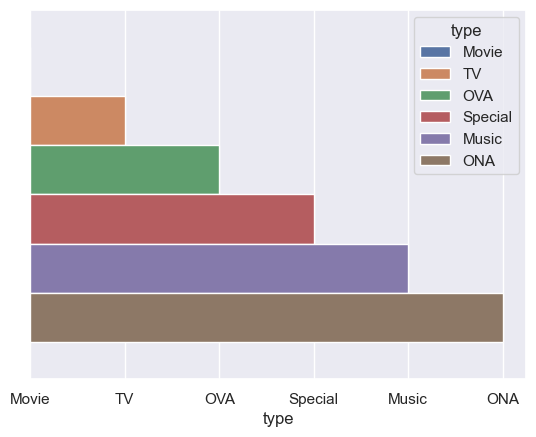

In [44]:
sns.barplot(data=anime_df, x="type", hue="type")

In [53]:
genres = anime_df["genre"].str.split(",").explode()

In [59]:
genre_count = genres.groupby(genres).count().sort_values(ascending=False)

In [64]:
genre_count = genre_count.reset_index(allow_duplicates=True)

In [65]:
genre_count

,genre,genre
0,action,2327
1,comedy,2161
2,sci-fi,1681
3,shounen,1490
4,fantasy,1392
...,...,...
69,martial arts,4
70,supernatural,3
71,josei,2
72,police,1


In [66]:
genre_count.columns = ["genre", "genre_count"]

In [ ]:
genre_count

,genre,genre_count
0,action,2327
1,comedy,2161
2,sci-fi,1681
3,shounen,1490
4,fantasy,1392
...,...,...
69,martial arts,4
70,supernatural,3
71,josei,2
72,police,1


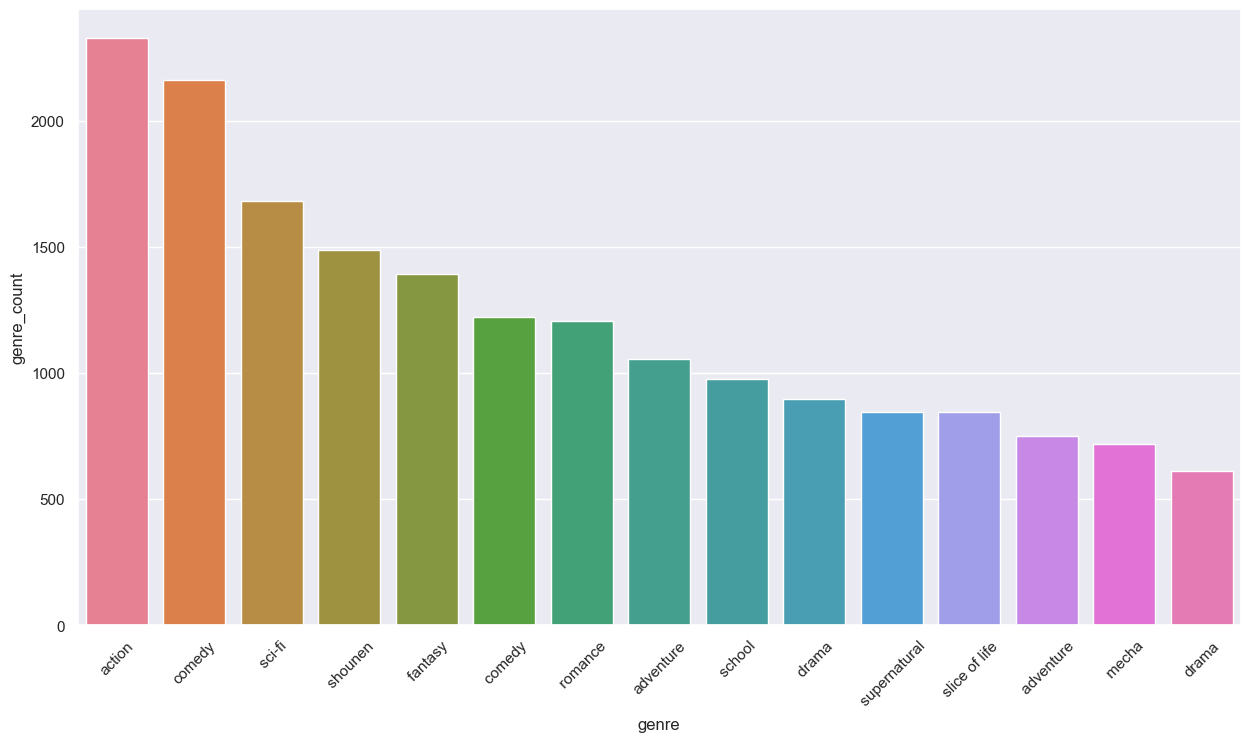

In [76]:
plt.figure(figsize=(15, 8))
sns.barplot(data=genre_count.head(15), x="genre", y="genre_count", hue="genre")
plt.xticks(rotation=45)
plt.show()

In [80]:
anime_df["episodes"].unique

<bound method Series.unique of 0        1
1       64
2       51
3       24
4       51
        ..
7581     1
7582     1
7583     1
7584     1
7585     1
Name: episodes, Length: 7586, dtype: object>

In [81]:
anime_df["episodes"] = anime_df["episodes"].str.strip()
anime_df["episodes"] = anime_df["episodes"].str.lower()
anime_df["episodes"]

0        1
1       64
2       51
3       24
4       51
        ..
7581     1
7582     1
7583     1
7584     1
7585     1
Name: episodes, Length: 7586, dtype: object

In [82]:
anime_df["episodes"].unique

<bound method Series.unique of 0        1
1       64
2       51
3       24
4       51
        ..
7581     1
7582     1
7583     1
7584     1
7585     1
Name: episodes, Length: 7586, dtype: object>

<Axes: xlabel='episodes', ylabel='count'>

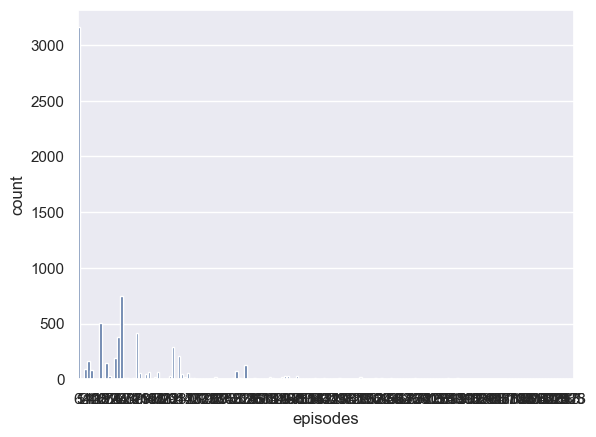

In [83]:
sns.countplot(data=anime_df, x="episodes")